In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from dateutil import tz
import scienceplots
import matplotlib.ticker as ticker
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib as mpl

In [6]:
mpl.rcParams.update({
    "font.family":        "sans-serif",
    "font.sans-serif":    ["Arial"],
    "font.size":          8.5,
    "axes.titlesize":     8.5,
    "axes.labelsize":     8.5,
    "xtick.labelsize":    8.0,
    "ytick.labelsize":    8.0,
    "legend.fontsize":    7.0,

    "axes.linewidth":     0.6,
    "xtick.direction":    "in",
    "ytick.direction":    "out",
    "xtick.major.size":   0.0,
    "xtick.major.width":  0.0,
    "ytick.major.size":   3.5,
    "ytick.major.width":  0.6,
    "xtick.minor.size":   1.5,
    "xtick.minor.width":  0.6,
    "ytick.minor.size":   1.8,
    "ytick.minor.width":  0.6,
    "xtick.minor.visible": False,
    "ytick.minor.visible": True,
    "xtick.major.pad":    3,
    "ytick.major.pad":    3,

    "axes.labelpad":      3,
    "axes.titlepad":      4,

    "lines.linewidth":    1.0,
    "axes.grid":          False,

    "savefig.bbox":       "tight",
    "savefig.dpi":        300,
})

In [7]:
def convert_timezone(time):
    return time + timedelta(hours=utc)

def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)

def calculate_metrics(observed, predicted):
    # Exclude NaN values
    observed_ = observed.flatten()
    predicted_ = predicted.flatten()
    valid_indices = ~np.isnan(observed_) & ~np.isnan(predicted_)
    observed_ = observed_[valid_indices]
    predicted_ = predicted_[valid_indices]

    if len(observed_) == 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    # Calculate correlation coefficient (R)
    correlation_coefficient, _ = pearsonr(observed_, predicted_)

    # Calculate root mean square error (RMSE)
    rmse = np.sqrt(mean_squared_error(observed_, predicted_))

    mod_sd = np.std(predicted_)
    obs_sd = np.std(observed_)

    mbe = np.mean(np.abs(predicted_ - observed_))
    std_ratio = mod_sd / obs_sd if obs_sd != 0 else np.nan

    return correlation_coefficient, rmse, mbe, mod_sd, obs_sd, std_ratio

In [8]:
colors = ['#DB9850', '#3B5387', '#D94738', '#6BB48F', 'dimgray']
urb_veg = '#6BB48F'#rgb_to_hex(221, 107, 79)
urbc = '#3B5387'#rgb_to_hex(80, 146, 150)
slabc = '#DB9850'#rgb_to_hex(229, 168, 75)
clm5c = '#D94738'#'#d62728'#rgb_to_hex(229, 168, 75)

In [9]:
def plot_seasonal_statistics_rad(plt_var1, plt_var2, plt_var3, plt_var4, ax, ymin, ymax):
    var_labels = ['SWup', 'LWup', 'Rnet']

    reshape_var1 = np.zeros((21, 3), dtype=float)
    reshape_var2 = np.zeros((21, 3), dtype=float)
    reshape_var3 = np.zeros((21, 3), dtype=float)
    reshape_var4 = np.zeros((21, 3), dtype=float)

    reshape_var1[:, 0:3] = plt_var1[:, 0:3]
    reshape_var2[:, 0:3] = plt_var2[:, 0:3]
    reshape_var3[:, 0:3] = plt_var3[:, 0:3]
    reshape_var4[:, 0:3] = plt_var4[:, 0:3]

    columns = var_labels

    df1 = pd.DataFrame(reshape_var1, columns=columns)
    df2 = pd.DataFrame(reshape_var2, columns=columns)
    df3 = pd.DataFrame(reshape_var3, columns=columns)
    df4 = pd.DataFrame(reshape_var4, columns=columns)

    df3['Source'] = r'$\mathregular{Slab}$'
    df2['Source'] = r'$\mathregular{Urb}$'
    df1['Source'] = r'$\mathregular{Urb_{veg}}$'
    df4['Source'] = r'$\mathregular{CLM5U}$'

    df = pd.concat([df3, df2, df1, df4], ignore_index=True)

    df_melted = df.melt(
        id_vars=['Source'],
        value_vars=['SWup', 'LWup', 'Rnet'],
        var_name='Variable',
        value_name='Value'
    )

    custom_palette = {
        r'$\mathregular{Slab}$'   : slabc,
        r'$\mathregular{Urb}$' : urbc,
        r'$\mathregular{Urb_{veg}}$'   : urb_veg,
        r'$\mathregular{CLM5U}$'       : clm5c,
    }

    sns.boxplot(
        data=df_melted,
        x="Variable",
        y="Value",
        hue="Source",
        palette=custom_palette,
        linewidth=0.8,
        fliersize=1.5,
        ax=ax,
        showfliers=False
    )

    for xpos in [0.5, 1.5]:
        ax.axvline(xpos, color="0.7", linestyle="--", linewidth=0.6, zorder=0)

    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(ymin, ymax)

    ax.set_xlabel("")
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['$SW_{up}$', '$LW_{up}$', '$R_{net}$'])

    ax.tick_params(axis='x', which='major', top=False)
    ax.tick_params(axis='y', which='major', right=False)
    ax.tick_params(axis='y', which='minor', right=False)

    if ymax > 1.5:
        if ymax - ymin >= 50:
            ax.yaxis.set_major_locator(MultipleLocator(20))
            ax.yaxis.set_minor_locator(MultipleLocator(5))
        else:
            ax.yaxis.set_major_locator(MultipleLocator(10))
            ax.yaxis.set_minor_locator(MultipleLocator(2.5))
    else:
        if ymin < 0.9:
            ax.yaxis.set_major_locator(MultipleLocator(0.1))
            ax.yaxis.set_minor_locator(MultipleLocator(0.05))
        else:
            ax.yaxis.set_major_locator(MultipleLocator(0.02))
            ax.yaxis.set_minor_locator(MultipleLocator(0.01))

    plt.legend().set_visible(False)

In [10]:
def plot_seasonal_statistics_tur(plt_var1, plt_var2, plt_var3, plt_var4, ax, ymin, ymax):
    var_labels = ['Qh', 'Qle', 'Qg']

    reshape_var1 = np.zeros((21, 3), dtype=float)
    reshape_var2 = np.zeros((21, 3), dtype=float)
    reshape_var3 = np.zeros((21, 3), dtype=float)
    reshape_var4 = np.zeros((21, 3), dtype=float)

    reshape_var1[:, :] = plt_var1[:, 3:6]
    reshape_var2[:, :] = plt_var2[:, 3:6]
    reshape_var3[:, :] = plt_var3[:, 3:6]
    reshape_var4[:, :] = plt_var4[:, 3:6]

    columns = var_labels

    df1 = pd.DataFrame(reshape_var1, columns=columns)
    df2 = pd.DataFrame(reshape_var2, columns=columns)
    df3 = pd.DataFrame(reshape_var3, columns=columns)
    df4 = pd.DataFrame(reshape_var4, columns=columns)

    df3['Source'] = r'$\mathregular{Slab}$'
    df2['Source'] = r'$\mathregular{Urb}$'
    df1['Source'] = r'$\mathregular{Urb_{veg}}$'
    df4['Source'] = r'$\mathregular{CLM5U}$'

    df = pd.concat([df3, df2, df1, df4], ignore_index=True)

    df_melted = df.melt(
        id_vars=['Source'],
        value_vars=['Qh', 'Qle', 'Qg'],
        var_name='Variable',
        value_name='Value'
    )

    custom_palette = {
        r'$\mathregular{Slab}$'   : slabc,
        r'$\mathregular{Urb}$' : urbc,
        r'$\mathregular{Urb_{veg}}$'   : urb_veg,
        r'$\mathregular{CLM5U}$'       : clm5c,
    }

    sns.boxplot(
        data=df_melted,
        x="Variable",
        y="Value",
        hue="Source",
        palette=custom_palette,
        linewidth=0.8,
        fliersize=1.5,
        ax=ax,
        showfliers=False
    )

    for xpos in [0.5, 1.5]:
        ax.axvline(xpos, color="0.7", linestyle="--", linewidth=0.6, zorder=0)

    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(ymin, ymax)

    ax.set_xlabel("")
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['$Q_h$', '$Q_{le}$', '$Q_g$'])

    ax.tick_params(axis='x', which='major', top=False)
    ax.tick_params(axis='y', which='major', right=False)
    ax.tick_params(axis='y', which='minor', right=False)

    if ymax > 1.5:
        if ymax - ymin >= 50:
            ax.yaxis.set_major_locator(MultipleLocator(20))
            ax.yaxis.set_minor_locator(MultipleLocator(5))
        else:
            ax.yaxis.set_major_locator(MultipleLocator(10))
            ax.yaxis.set_minor_locator(MultipleLocator(2.5))
    else:
        if ymin < 0.9:
            ax.yaxis.set_major_locator(MultipleLocator(0.1))
            ax.yaxis.set_minor_locator(MultipleLocator(0.05))
        else:
            ax.yaxis.set_major_locator(MultipleLocator(0.02))
            ax.yaxis.set_minor_locator(MultipleLocator(0.01))

    plt.legend().set_visible(False)

In [17]:
site = [
    'AU-Preston', 'AU-SurreyHills', 'CA-Sunset', 'FI-Kumpula', 'FI-Torni', 'FR-Capitole',
    'GR-HECKOR', 'JP-Yoyogi', 'KR-Jungnang', 'KR-Ochang', 'MX-Escandon', 'NL-Amsterdam',
    'PL-Lipowa', 'PL-Narutowicza', 'SG-TelokKurau06', 'UK-KingsCollege', 'UK-Swindon',
    'US-Baltimore', 'US-Minneapolis1', 'US-Minneapolis2', 'US-WestPhoenix'
]

In [12]:
mod_nam = ['f_sr', 'f_olrg', 'f_rnet', 'f_fsena', 'f_lfevpa', 'f_fgrnd']
obs_nam = ['SWup', 'LWup', 'Rnet', 'Qh', 'Qle', 'Qg']
clm_nam = ['SWup_cesmlcz', 'LWup_cesmlcz', 'Rn_cesmlcz', 'Qh_cesmlcz', 'Qle_cesmlcz', 'Qg']
clm_obs = ['SWup_obs', 'LWup_obs', 'Rn_obs', 'Qh_obs', 'Qle_obs', 'Qg']

In [13]:
R_mod1    = np.zeros((21, 6), dtype=float)
RMSE_mod1 = np.zeros((21, 6), dtype=float)
MBE_mod1  = np.zeros((21, 6), dtype=float)
STD_mod1  = np.zeros((21, 6), dtype=float)

R_mod2    = np.zeros((21, 6), dtype=float)
RMSE_mod2 = np.zeros((21, 6), dtype=float)
MBE_mod2  = np.zeros((21, 6), dtype=float)
STD_mod2  = np.zeros((21, 6), dtype=float)

R_mod3    = np.zeros((21, 6), dtype=float)
RMSE_mod3 = np.zeros((21, 6), dtype=float)
MBE_mod3  = np.zeros((21, 6), dtype=float)
STD_mod3  = np.zeros((21, 6), dtype=float)

R_mod4    = np.zeros((21, 6), dtype=float)
RMSE_mod4 = np.zeros((21, 6), dtype=float)
MBE_mod4  = np.zeros((21, 6), dtype=float)
STD_mod4  = np.zeros((21, 6), dtype=float)

In [15]:
obs_f   = f'../../model_output/obs/'

for i in range(len(site)):
    veg_f   = f'../../model_output/veg/{site[i]}/history/'
    noveg_f = f'../../model_output/urb/{site[i]}/history/'
    slab_f  = f'../../model_output/slab/{site[i]}/history/'
    clm5_f  = f'../../model_output/clm5/output/'

    mod1_ds = xr.open_dataset(veg_f + site[i] + '.nc')
    mod2_ds = xr.open_dataset(noveg_f + site[i] + '.nc')
    mod3_ds = xr.open_dataset(slab_f + site[i] + '.nc')
    clm_ds  = pd.read_csv(f'{clm5_f}{site[i]}.csv')
    obs_ds  = xr.open_dataset(obs_f + site[i] + '_clean_observations_v1.nc')

    utc = obs_ds.attrs.get('local_utc_offset_hours')

    print(f'Processing {site[i]}...')

    for j in range(len(mod_nam)):
        
        mod_var  = mod_nam[j]
        obs_var  = obs_nam[j]
        clm_var  = clm_nam[j]
        clm_obs1 = clm_obs[j]

        if site[i] == 'MX-Escandon' and (obs_var in ['LWup', 'Rnet', 'Qg']):
            R_mod1[i, j] = np.nan
            RMSE_mod1[i, j] = np.nan
            MBE_mod1[i, j] = np.nan
            STD_mod1[i, j] = np.nan

            R_mod2[i, j] = np.nan
            RMSE_mod2[i, j] = np.nan
            MBE_mod2[i, j] = np.nan
            STD_mod2[i, j] = np.nan

            R_mod3[i, j] = np.nan
            RMSE_mod3[i, j] = np.nan
            MBE_mod3[i, j] = np.nan
            STD_mod3[i, j] = np.nan

            R_mod4[i, j] = np.nan
            RMSE_mod4[i, j] = np.nan
            MBE_mod4[i, j] = np.nan
            STD_mod4[i, j] = np.nan

            continue

        if obs_var == 'Rnet':
            var_mod1 = mod1_ds['f_xy_solarin'] + mod1_ds['f_xy_frl'] - mod1_ds['f_sr'] - mod1_ds['f_olrg']
            var_mod2 = mod2_ds['f_xy_solarin'] + mod2_ds['f_xy_frl'] - mod2_ds['f_sr'] - mod2_ds['f_olrg']
            var_mod3 = mod3_ds['f_xy_solarin'] + mod3_ds['f_xy_frl'] - mod3_ds['f_sr'] - mod3_ds['f_olrg']
            var_clm  = clm_ds['Rn_cesmlcz']
            obs_clm  = clm_ds['Rn_obs']

            SWdown   = xr.where((mod1_ds['f_xy_solarin'] == 0), 0, obs_ds['SWdown'][:-1])
            SWup     = xr.where((mod1_ds['f_xy_solarin'] == 0), 0, obs_ds['SWup'][:-1])
            LWdown   = obs_ds['LWdown'][:-1]
            LWup     = obs_ds['LWup'][:-1]
            var_obs  = SWdown + LWdown - SWup - LWup

        elif obs_var == 'Qg':
            var_mod1 = (mod1_ds['f_xy_solarin'] + mod1_ds['f_xy_frl']
                        - mod1_ds['f_sr'] - mod1_ds['f_olrg']
                        - mod1_ds['f_fsena'] - mod1_ds['f_lfevpa'])
            var_mod2 = (mod2_ds['f_xy_solarin'] + mod2_ds['f_xy_frl']
                        - mod2_ds['f_sr'] - mod2_ds['f_olrg']
                        - mod2_ds['f_fsena'] - mod2_ds['f_lfevpa'])
            var_mod3 = mod3_ds['f_fgrnd']

            SWdown   = xr.where((mod1_ds['f_xy_solarin'] == 0), 0, obs_ds['SWdown'][:-1])
            SWup     = xr.where((mod1_ds['f_xy_solarin'] == 0), 0, obs_ds['SWup'][:-1])
            LWdown   = obs_ds['LWdown'][:-1]
            LWup     = obs_ds['LWup'][:-1]
            var_obs  = SWdown + LWdown - SWup - LWup - obs_ds['Qh'][:-1] - obs_ds['Qle'][:-1]

            var_clm  = clm_ds['Rn_cesmlcz'] - clm_ds['Qh_cesmlcz'] - clm_ds['Qle_cesmlcz']
            obs_clm  = clm_ds['Rn_obs'] - clm_ds['Qh_obs'] - clm_ds['Qle_obs']

        else:
            var_mod1 = mod1_ds[mod_var]
            var_mod2 = mod2_ds[mod_var]
            var_mod3 = mod3_ds[mod_var]
            var_clm  = clm_ds[clm_var]
            obs_clm  = clm_ds[clm_obs1]
            var_obs  = obs_ds[obs_var][:-1]

        # urb_Veg
        R, RMSE, MBE, mod_sd, obs_sd, std_ratio = calculate_metrics(var_obs.values, var_mod1.values)
        R_mod1[i, j]    = R
        RMSE_mod1[i, j] = RMSE
        MBE_mod1[i, j]  = MBE
        STD_mod1[i, j]  = std_ratio

        # Urb
        R, RMSE, MBE, mod_sd, obs_sd, std_ratio = calculate_metrics(var_obs.values, var_mod2.values)
        R_mod2[i, j]    = R
        RMSE_mod2[i, j] = RMSE
        MBE_mod2[i, j]  = MBE
        STD_mod2[i, j]  = std_ratio

        # Slab
        R, RMSE, MBE, mod_sd, obs_sd, std_ratio = calculate_metrics(var_obs.values, var_mod3.values)
        R_mod3[i, j]    = R
        RMSE_mod3[i, j] = RMSE
        MBE_mod3[i, j]  = MBE
        STD_mod3[i, j]  = std_ratio

        # CLM5U
        R, RMSE, MBE, mod_sd, obs_sd, std_ratio = calculate_metrics(obs_clm.values, var_clm.values)
        R_mod4[i, j]    = R
        RMSE_mod4[i, j] = RMSE
        MBE_mod4[i, j]  = MBE
        STD_mod4[i, j]  = std_ratio

    mod1_ds.close()
    mod2_ds.close()
    mod3_ds.close()
    obs_ds.close()


Processing AU-Preston...
Processing AU-SurreyHills...
Processing CA-Sunset...
Processing FI-Kumpula...
Processing FI-Torni...
Processing FR-Capitole...
Processing GR-HECKOR...
Processing JP-Yoyogi...
Processing KR-Jungnang...
Processing KR-Ochang...
Processing MX-Escandon...
Processing NL-Amsterdam...
Processing PL-Lipowa...
Processing PL-Narutowicza...
Processing SG-TelokKurau06...
Processing UK-KingsCollege...
Processing UK-Swindon...
Processing US-Baltimore...
Processing US-Minneapolis1...
Processing US-Minneapolis2...
Processing US-WestPhoenix...


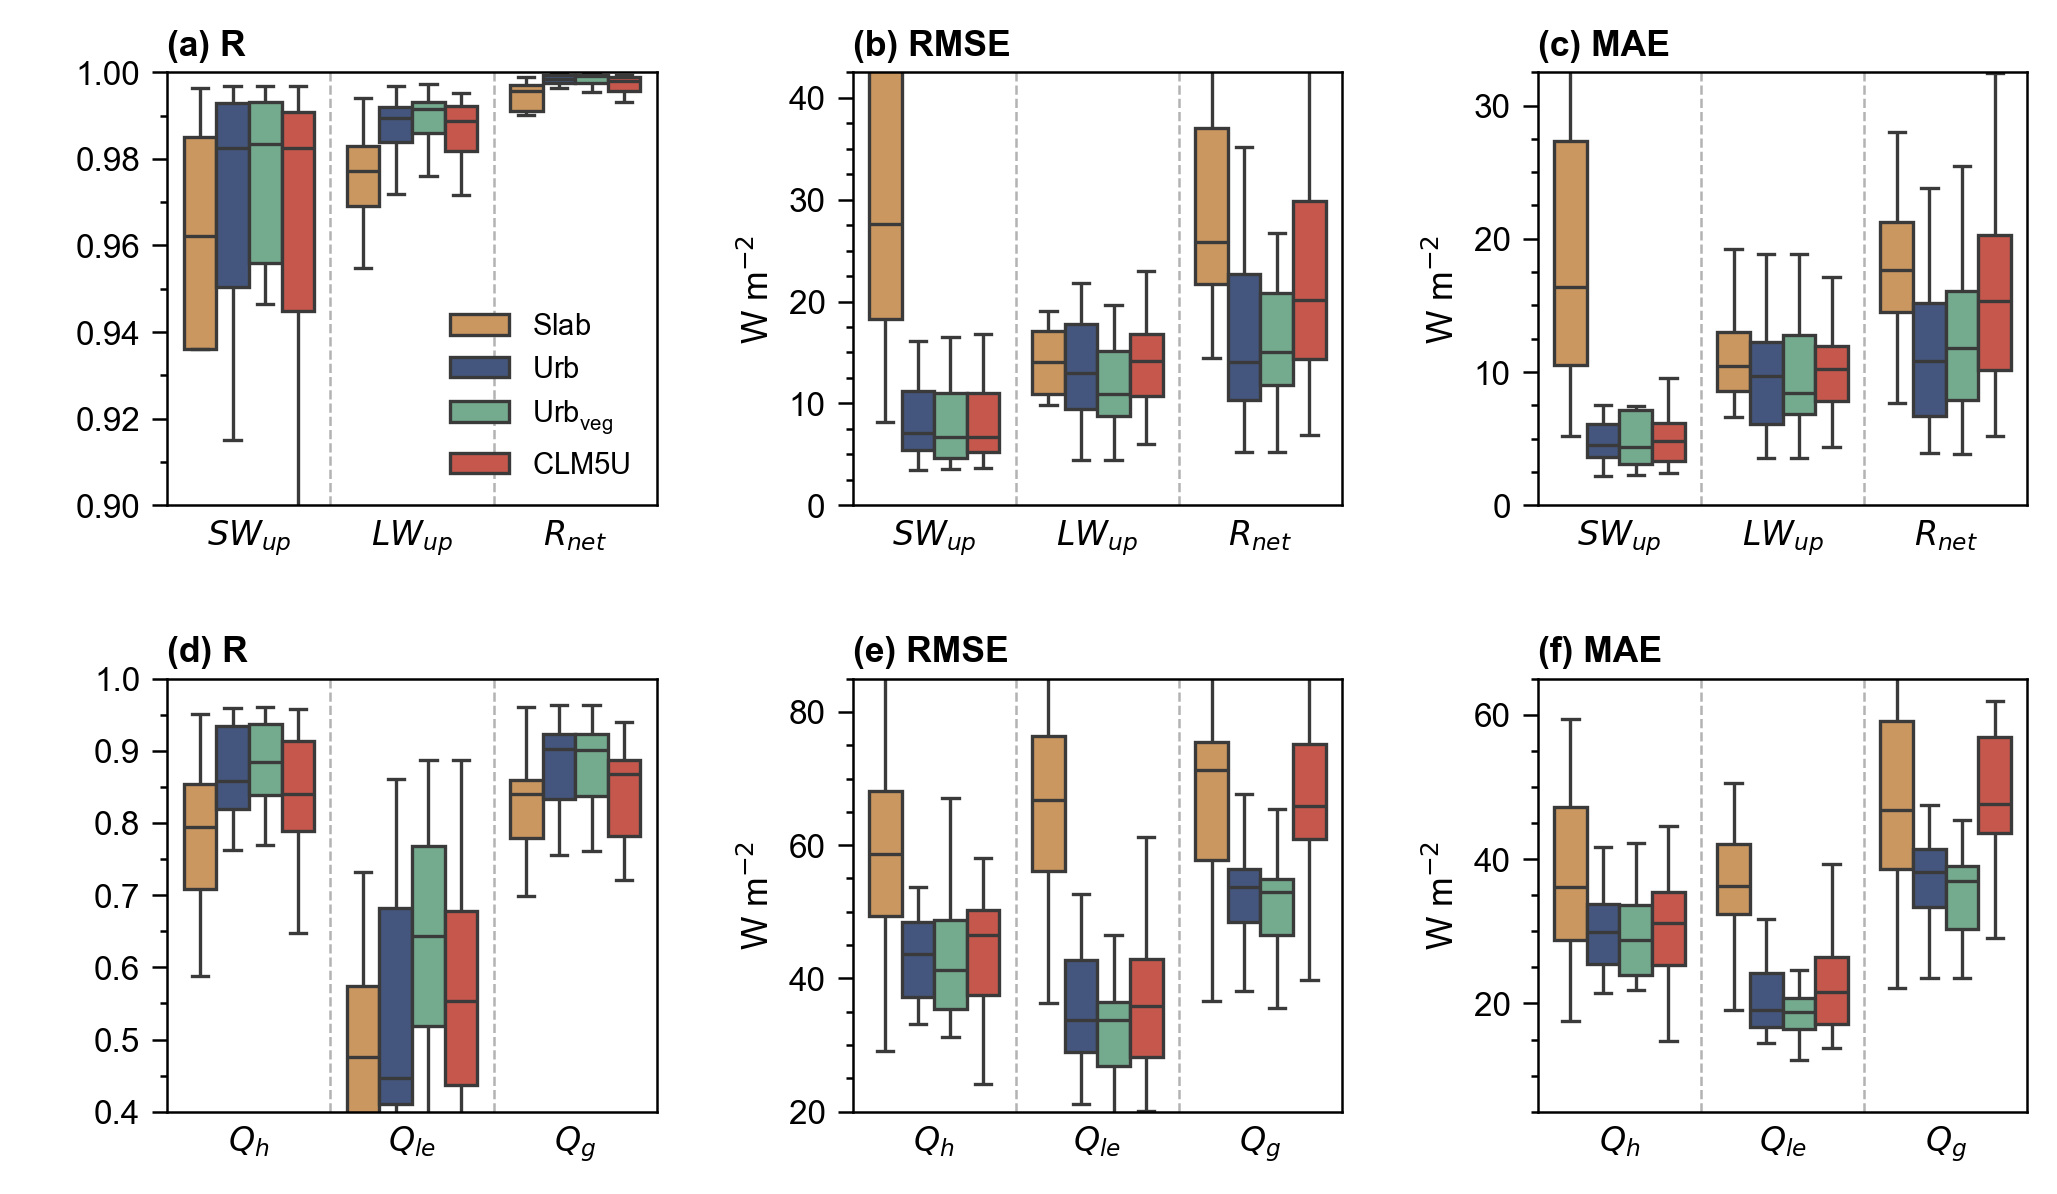

In [16]:
#fig = plt.figure(figsize=(7.2, 4.5), dpi=300)
fig = plt.figure(figsize=(8, 4.5), dpi=300)

ax_ref = None

for i in range(6):
    ax = plt.subplot(2, 3, i + 1)

    if i == 0:
        ax.set_title('(a) R', loc='left', fontweight='bold')
        ax.set_ylabel(' ')
        plot_seasonal_statistics_rad(R_mod1, R_mod2, R_mod3, R_mod4, ax, 0.9, 1.0)
        ax_ref = ax
        ax.legend(facecolor="none", ncol=1, edgecolor="none", loc="lower right")

    elif i == 1:
        ax.set_title('(b) RMSE', loc='left', fontweight='bold')
        ax.set_ylabel('W m$^{-2}$')
        plot_seasonal_statistics_rad(RMSE_mod1, RMSE_mod2, RMSE_mod3, RMSE_mod4, ax, 0, 42.5)

    elif i == 2:
        ax.set_title('(c) MAE', loc='left', fontweight='bold')
        ax.set_ylabel('W m$^{-2}$')
        plot_seasonal_statistics_rad(MBE_mod1, MBE_mod2, MBE_mod3, MBE_mod4, ax, 0, 32.5)

    elif i == 3:
        ax.set_title('(d) R', loc='left', fontweight='bold')
        ax.set_ylabel(' ')
        plot_seasonal_statistics_tur(R_mod1, R_mod2, R_mod3, R_mod4, ax, 0.4, 1.0)

    elif i == 4:
        ax.set_title('(e) RMSE', loc='left', fontweight='bold')
        ax.set_ylabel('W m$^{-2}$')
        plot_seasonal_statistics_tur(RMSE_mod1, RMSE_mod2, RMSE_mod3, RMSE_mod4, ax, 20, 85)

    elif i == 5:
        ax.set_title('(f) MAE', loc='left', fontweight='bold')
        ax.set_ylabel('W m$^{-2}$')
        plot_seasonal_statistics_tur(MBE_mod1, MBE_mod2, MBE_mod3, MBE_mod4, ax, 5, 65)

fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.savefig('Figure16.jpg')
plt.show()